In [2]:
import dv_processing as dv
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_save_max_last_refact
from snn_delays.utils.visualization_utils import plot_conv_filters

device = get_device()
dataset = 'davis_loihi'
total_time = 100
batch_size = 64
folder_name = 'FromLoihi_ABCXO_15Hz_64_robust'

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 64,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[Downsample(time_factor=1, spatial_factor=1.0, sensor_size=None, target_size=None), ToFrame(sensor_size=(64, 64, 2), time_window=None, event_count=None, n_time_bins=100, n_event_bins=None, overlap=0, include_incomplete=False)]


In [3]:
dataset_dict['time_ms'] = 100
dataset_dict

{'num_input': 8192,
 'num_input_channels': 2,
 'num_training_samples': 7500,
 'num_output': 5,
 'dataset_name': 'davis_loihi',
 'time_ms': 100}

Delta t: 1.0 ms
SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=384, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=5, bias=False)
    )
  )
)


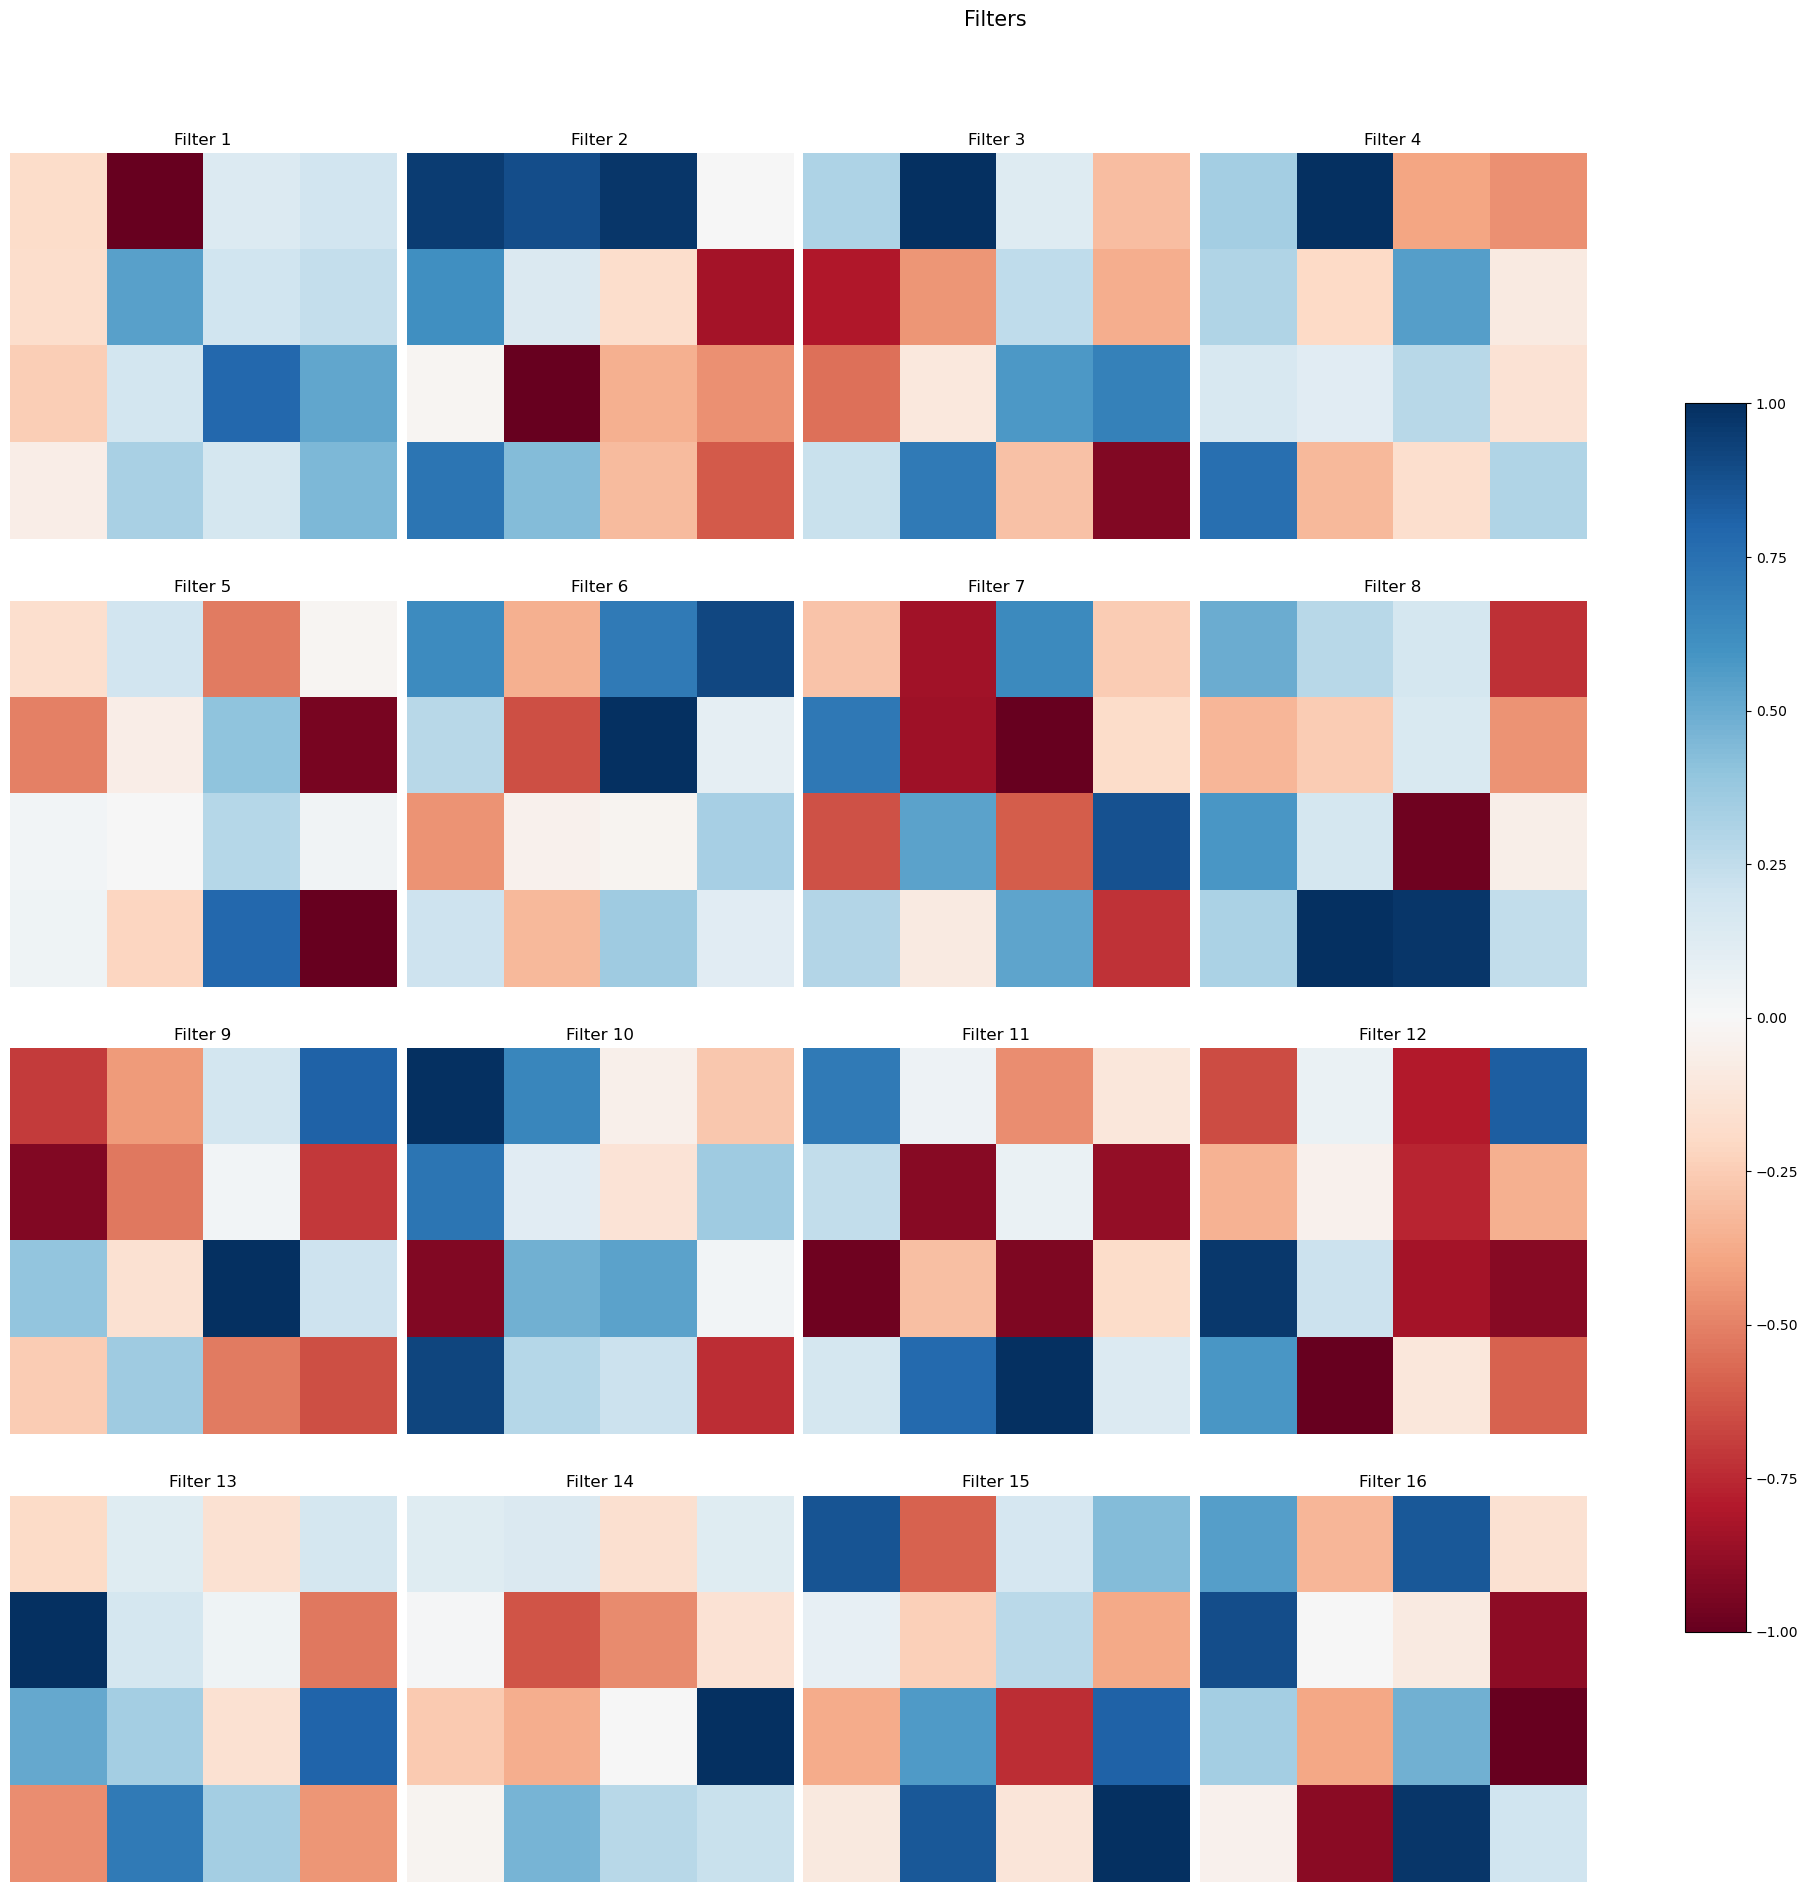

In [9]:
ckpt_dir = 'abcxo_64_Conv_15Hz'

structure = (96, 2, 'f')

extra_kwargs = {'conv':[(2, 16, 4), (16, 24, 4)]}

#extra_kwargs = {}

#tau_m = 50 # initial experiments
tau_m = 5.0 

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m=tau_m, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device, 
          **extra_kwargs)

#snn.input2spike_th = 0.5

snn.model_name = 'abcxo_f'
snn.set_layers()
snn.to(device)
print(snn)

plot_conv_filters(snn.layers[0])

Epoch [1/20], learning_rates 0.001000, 0.100000
Step [39/117], Loss: 0.16218
Step [78/117], Loss: 0.13399
Step [117/117], Loss: 0.13515
Time elasped: 81.1948356628418
1456
Test Loss: 0.12151564657688141
Avg spk_count per neuron for all 100 time-steps 2457.855494505495
Test Accuracy of the model on the test samples: 67.308

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_64_Conv_15Hz
saving max acc: 67.3076923076923
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_64_Conv_15Hz
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [39/117], Loss: 0.10450
Step [78/117], Loss: 0.10757
Step [117/117], Loss: 0.08266
Time elasped: 81.88046717643738
1456
Test Loss: 0.07936040992322176
Avg spk_count per neuron for all 100 time-steps 3629.2825549450554
Test Accuracy of the model on the test samples: 87.225

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_6

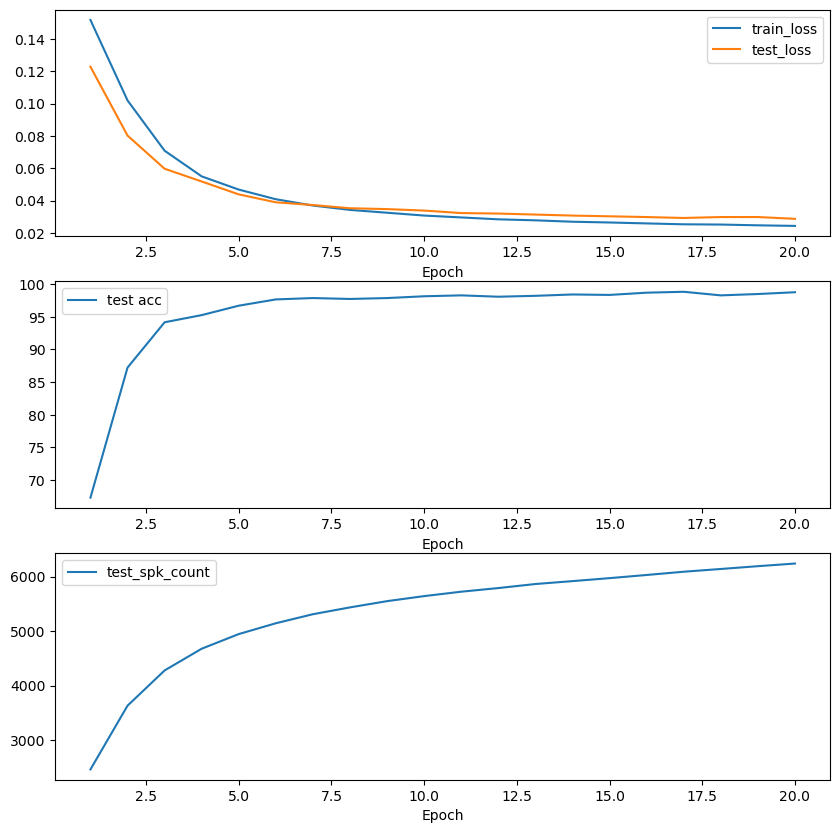

In [10]:
num_epochs = 20
lr = 1e-3
train(snn, train_loader, test_loader, lr, num_epochs, ckpt_dir=ckpt_dir,
       test_behavior=tb_save_max_last_refact, scheduler=(10, 0.95), test_every=1, freeze_taus=True)

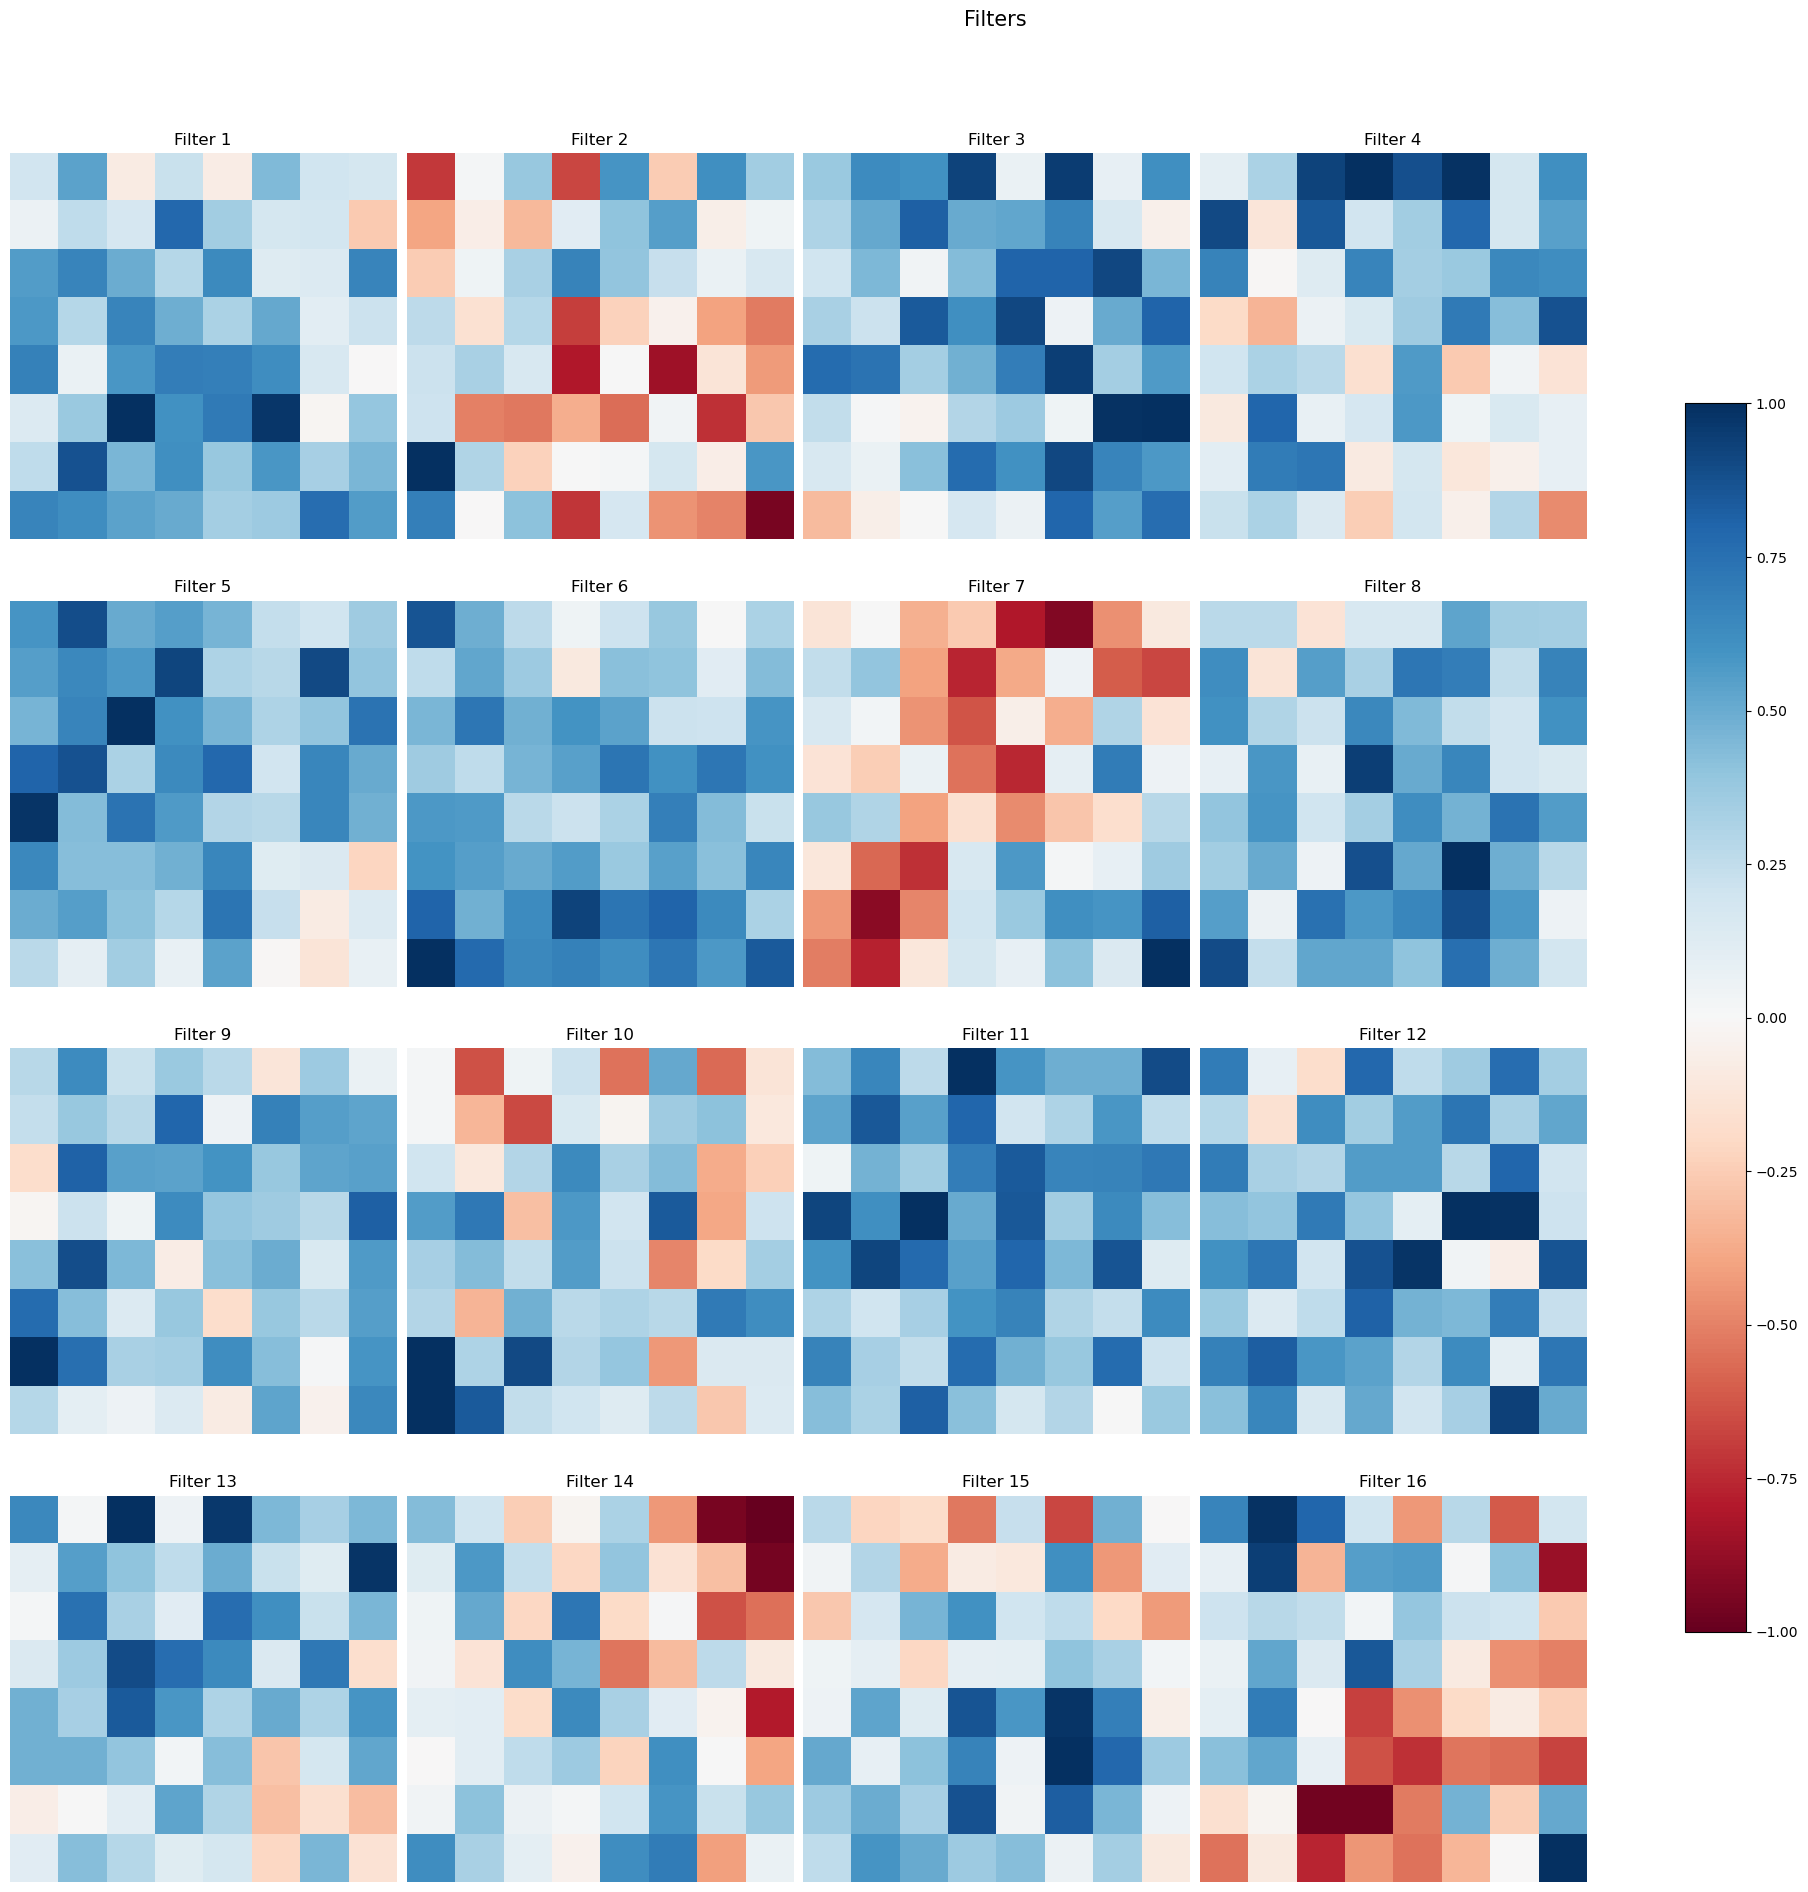

In [5]:
plot_conv_filters(snn.layers[0])

Delta t: 1.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=384, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=5, bias=False)
    )
  )
  (criterion): MSELoss()
)


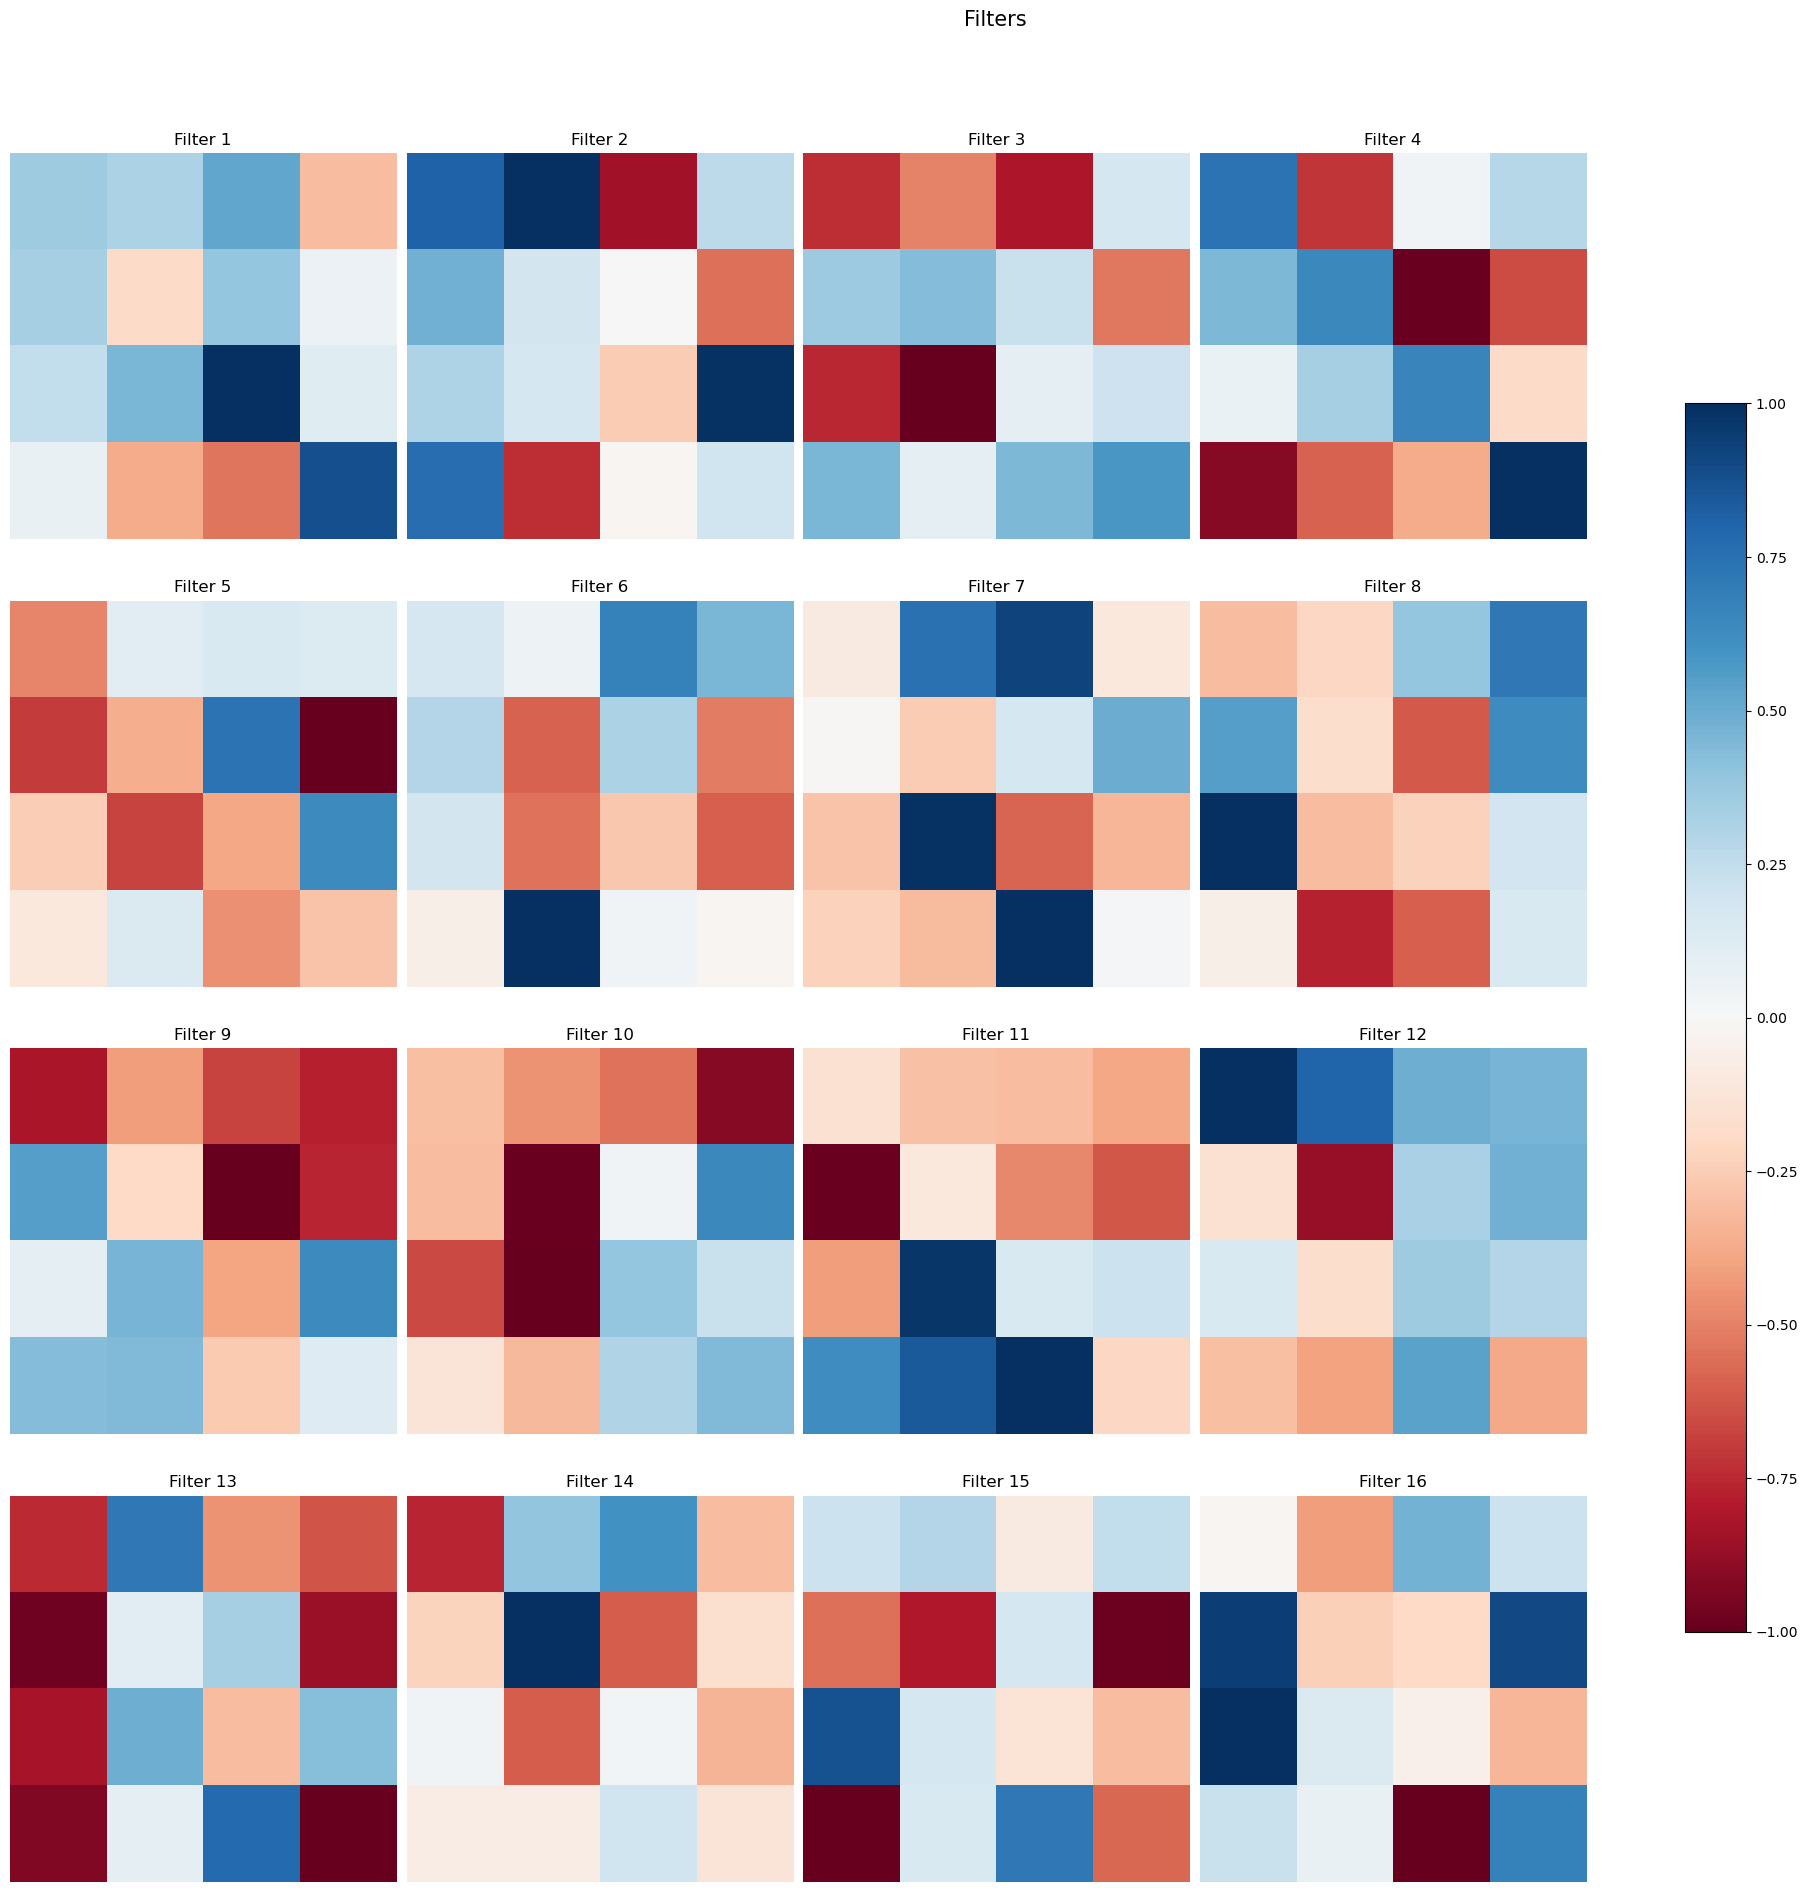

In [4]:
ckpt_dir = 'abcxo_64_Conv_15Hz'

structure = (96, 2, 'f')

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4, 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4, 
    }, 
    {
        'type': 'Flatten'
    },     
    {
        'type': 'Feedforward', 
        'num_out': 96       
    },
    {
        'type': 'Feedforward', 
        'num_out': 96        
    }
]

#tau_m = 50 # initial experiments
tau_m = 5.0 

snn = SNN(dataset_dict=dataset_dict, model_config=model_config, tau_m=tau_m, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device)

#snn.input2spike_th = 0.5

snn.model_name = 'abcxo_conv2'
snn.set_layers()
snn.to(device)
print(snn)

plot_conv_filters(snn.layers[0])

In [5]:
num_epochs = 20
lr = 1e-3
train(snn, train_loader, test_loader, lr, num_epochs, ckpt_dir=ckpt_dir,
       test_behavior=tb_save_max_last_refact, scheduler=(10, 0.95), test_every=1, freeze_taus=True)

Epoch [1/20], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [39/117], Loss: 0.16328
Step [78/117], Loss: 0.14431
Step [117/117], Loss: 0.13315
Time elasped: 173.9153618812561
1456
Test Loss: 0.12743631329225458
Avg spk_count per neuron for all 100 time-steps 2251.709615384615
Test Accuracy of the model on the test samples: 62.363

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_64_Conv_15Hz
saving max acc: 62.362637362637365
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_64_Conv_15Hz
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [39/117], Loss: 0.11725
Step [78/117], Loss: 0.10313
Step [117/117], Loss: 0.09301
Time elasped: 89.94257473945618
1456
Test Loss: 0.08953808636769005
Avg spk_count per neuron for all 100 time-steps 3378.4711538461543
Test Accuracy of the model on the test samples: 83.242

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_64_Conv_15Hz
saving max acc: 83.24175824175825

KeyboardInterrupt: 